## Calculate PERMANOVA Adonis R2

### All

In [1]:
system('unzip -d Jaccard/ Jaccard/jaccard_distance_matrix.qza')

load libraries

In [1]:
library(vegan)
library(ggplot2)

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



load distance matrices

In [2]:
dis_jaccard <- read.table(paste(list.dirs(path = "Jaccard/")[3],list.files(list.dirs(path = "Jaccard/")[3]),sep="/"),sep = "\t",header=T, row.names = 1)

load metadata

In [3]:
md <- read.csv('MetaData_Superfood.tsv', sep = '\t', stringsAsFactors = F)

In [4]:
distances <- list(dis_jaccard)
names(distances) <- c("jaccard")

# bring all rows and columns of distance matrices in same order
for (i in 1:length(distances)){
  distances[[i]] <- distances[[i]][match(rownames(distances[[1]]),rownames(distances[[i]])),]
  distances[[i]] <- distances[[i]][,match(colnames(distances[[1]]),colnames(distances[[i]]))]
}

In [5]:
all(sapply(rownames(distances), FUN = identical, dis_bray)) # should be TRUE

[1] TRUE

In [6]:
head(md)

X.SampleID,BarcodeSequence,LinkerPrimerSequence,ATTRIBUTE_sample_type_group5,ATTRIBUTE_superfood,ATTRIBUTE_sample_type_group4,organic,ATTRIBUTE_family_genus,gluten_free,filename,packaging,presample_ethanol_weight,botanical_genus,ATTRIBUTE_botanical_anatomy,final_ethanol_weight,gmo,sample_in_tube_ethanol_weight,sample_type_group6,ATTRIBUTE_GNPSDefaultGroup
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
72475_1x_BC9_01_17418,GATACA,GATACA,garlic,superfood,vegetable,yes,Amaryllidaceae,no,72475_1x_BC9_01_17418.mzXML,none,1.9269,allium,stem,2.0369,no,0.11,garlic,Not Mapped
72497_1x_BD7_01_17434,GATACA,GATACA,melon,non_superfood,pepo,no,Cucurbitaceae,yes,72497_1x_BD7_01_17434.mzXML,none,1.9243,Cucumis,fruit,2.1797,no,0.2554,galia,G1
72500_1x_BG3_01_17471,GATACA,GATACA,apple,non_superfood,pome,yes,Rosaceae,yes,72500_1x_BG3_01_17471.mzXML,glass,1.95,Malus,fruit,2.3257,no,0.3757,apple,G1
72504_1x_BH8_01_17502,GATACA,GATACA,fig,non_superfood,multifruit,yes,Moraceae,yes,72504_1x_BH8_01_17502.mzXML,plastic,1.9545,ficus,fruit,2.1733,no,0.2188,turkish fig,G1
72537_1x_BG5_01_17486,GATACA,GATACA,tomato,non_superfood,berry,yes,Solanaceae,no,72537_1x_BG5_01_17486.mzXML,plastic,1.9385,Solanum,fruit,2.1044,no,0.1659,orange cherry tomato,Not Mapped
72538_1x_BB6_01_17402,GATACA,GATACA,cabbage,non_superfood,vegetable,no,Brassicaceae,yes,72538_1x_BB6_01_17402.mzXML,none,1.9421,brassica,leaf,2.0412,no,0.0991,napa cabbage,G1


In [7]:
metadata <- md
rownames(metadata) <- md$X.SampleID
metadata <- metadata[which(rownames(metadata)%in%rownames(distances[[1]])),]
metadata <- metadata[match(rownames(distances[[1]]),rownames(metadata)),]

In [8]:
dim(distances[[1]])
dim(metadata)

[1] 564 564

[1] 564  19

In [9]:
cats <- c('ATTRIBUTE_botanical_anatomy','ATTRIBUTE_superfood')

In [10]:
Rsq <- c()
pval <- c()
for (i in 1:length(cats)){
  for (j in 1:length(distances)){
    if (length(which(is.na(metadata[,colnames(metadata) == cats[i]]))) !=0){
      red <- as.dist(distances[[j]][-which(is.na(metadata[,colnames(metadata) == cats[i]])),-which(is.na(metadata[,colnames(metadata) == cats[i]]))])
      Rsq <- c(Rsq,adonis(red ~ na.omit(metadata[,colnames(metadata) == cats[i]]))$aov.tab$R2[1])
      pval <- c(pval,adonis(red ~ na.omit(metadata[,colnames(metadata) == cats[i]]))$aov.tab$'Pr(>F)'[1])
    } else {
      Rsq <- c(Rsq,adonis(as.dist(distances[[j]]) ~ metadata[,colnames(metadata) == cats[i]])$aov.tab$R2[1])
      pval <- c(pval,adonis(as.dist(distances[[j]]) ~ metadata[,colnames(metadata) == cats[i]])$aov.tab$'Pr(>F)'[1])
    }
  }
}

In [11]:
out <- matrix(0, length(cats)*length(distances),4)
out[,1] <- rep(cats,each=length(distances))  
out[,2] <- rep(names(distances),length(cats))
out[,3] <- Rsq
out[,4] <- pval

colnames(out) <- c("metadata","metric","AdonisR2","pvalue")
out <- as.data.frame(out)
out$AdonisR2 <- as.numeric(as.character(out$AdonisR2))
out$pvalue <- as.numeric(as.character(out$pvalue))

# perform FDR correction within groups
out$pvalue_corr <- out$pvalue
for (i in 1:length(cats)){
  out$pvalue_corr[which(out$metadata==cats[i])]  <- p.adjust(out$pvalue_corr[which(out$metadata==cats[i])],method = "fdr")
}

out$sig <- out$pvalue_corr
out$sig[out$sig>0.05] <- "p>0.05"
out$sig[out$sig<0.05] <- "p<0.05"
out$sig <- as.factor(out$sig)

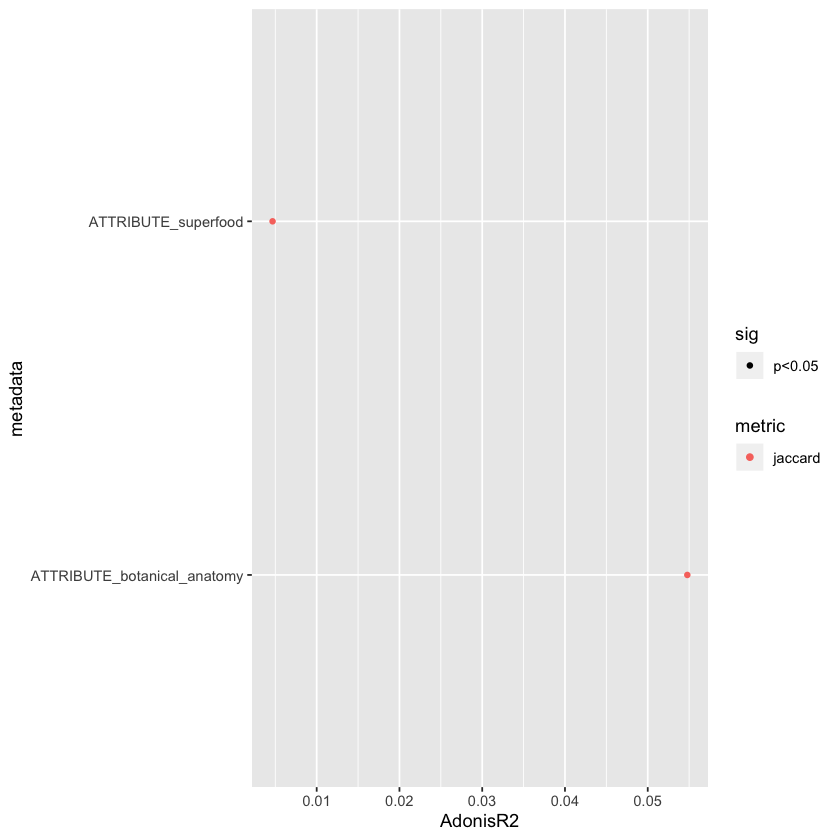

In [12]:
ggplot(out, aes(AdonisR2, metadata)) +
  geom_point(aes(color = metric, shape = sig)) #alpha = "0.3"s

In [13]:
pdf(file="AdonisR2_All.pdf", width=6, height=4)
ggplot(out, aes(AdonisR2, metadata)) +
  geom_point(aes(color = metric, shape = sig)) #alpha = "0.3"
dev.off()

pdf 
  2

In [14]:
write.table(out,'AdonisR2_All.txt',sep = '\t', row.names = F, quote = F)

In [15]:
out

metadata,metric,AdonisR2,pvalue,pvalue_corr,sig
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
ATTRIBUTE_botanical_anatomy,jaccard,0.054782725,0.001,0.001,p<0.05
ATTRIBUTE_superfood,jaccard,0.004669596,0.001,0.001,p<0.05
